In [1]:
import pandas as pd
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import optuna
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

### Creacion Clase Ternaria

In [2]:
dataset_raw = pd.read_csv("competencia_01_crudo.csv")

In [3]:
def clase_ternaria_optimizada(data_usuario):
    meses_existentes = set(data_usuario['foto_mes'].unique())
    clases = []

    for mes_actual in data_usuario['foto_mes']:
        mes_siguiente = mes_actual + 1
        mes_siguiente_2 = mes_actual + 2

        if mes_siguiente_2 in meses_existentes:
            clase = 'CONTINUA'
        elif mes_siguiente not in meses_existentes:
            clase = 'BAJA+1'
        else:
            clase = 'BAJA+2'
        clases.append(clase)

    return clases

def aplicar_clase_ternaria_optimizada(data, output_file='resultado_parcial.csv'):
    # Si el archivo existe, eliminarlo para no duplicar datos
    with open(output_file, 'w') as f:
        pass

    usuarios = data['numero_de_cliente'].unique()

    for i, usuario in enumerate(usuarios, 1):
        data_usuario = data[data['numero_de_cliente'] == usuario].copy()
        data_usuario['clase_ternaria'] = clase_ternaria_optimizada(data_usuario)

        # Guardar los resultados parciales en el archivo CSV (modo 'append')
        data_usuario.to_csv(output_file, mode='a', header=(i == 1), index=False)

        # Opción: Imprimir progreso
        if i % 100 == 0:
            print(f"Procesados {i} usuarios de {len(usuarios)}")

    print(f"Proceso completado. Resultados guardados en '{output_file}'.")

In [ ]:
competencia_01 = aplicar_clase_ternaria_optimizada(dataset_raw)

In [4]:
competencia_01 = pd.read_csv('competencia_01.csv')

In [5]:
competencia_01[competencia_01['foto_mes']==202106].shape

(164876, 155)

### Data Quality

In [6]:
df_nulos = pd.DataFrame(competencia_01.isnull().sum() / competencia_01.shape[0])
df_nulos.columns = ['proporcion_nulos']

In [7]:
columnas_de_nulos = list(df_nulos[df_nulos['proporcion_nulos']>0.4].index)

In [8]:
df_nulos

,proporcion_nulos
numero_de_cliente,0.000000
foto_mes,0.000000
active_quarter,0.000000
cliente_vip,0.000000
internet,0.000000
...,...
Visa_mconsumototal,0.136049
Visa_cconsumos,0.136049
Visa_cadelantosefectivo,0.136049
Visa_mpagominimo,0.049736


In [9]:
competencia_01 = competencia_01.drop(columns=columnas_de_nulos)

In [10]:
dolar_blue_2021 = {
    "01": 156.00,
    "02": 147.00,
    "03": 141.00,
    "04": 153.00,
    "05": 157.00,
    "06": 170.00,
    "07": 178.00,
    "08": 182.00,
    "09": 186.50,
    "10": 196.00,
    "11": 201.50,
    "12": 208.50
}

In [11]:
columnas_dinero = [
    "mrentabilidad",
    "mrentabilidad_annual",
    "mcomisiones",
    "mactivos_margen",
    "mpasivos_margen",
    "mcuenta_corriente_adicional",
    "mcuenta_corriente",
    "mcaja_ahorro",
    "mcaja_ahorro_adicional",
    "mcaja_ahorro_dolares",
    "mcuentas_saldo",
    "mautoservicio",
    "mtarjeta_visa_consumo",
    "mtarjeta_master_consumo",
    "mprestamos_personales",
    "mprestamos_prendarios",
    "mprestamos_hipotecarios",
    "mplazo_fijo_dolares",
    "mplazo_fijo_pesos",
    "minversion1_pesos",
    "minversion1_dolares",
    "minversion2",
    "mpayroll",
    "mpayroll2",
    "mcuenta_debitos_automaticos",
    "mtarjeta_visa_debitos_automaticos",
    "mttarjeta_master_debitos_automaticos",
    "mpagodeservicios",
    "mpagomiscuentas",
    "mcajeros_propios_descuentos",
    "mtarjeta_visa_descuentos",
    "mtarjeta_master_descuentos",
    "mcomisiones_mantenimiento",
    "mcomisiones_otras",
    "mforex_buy",
    "mforex_sell",
    "mtransferencias_recibidas",
    "mtransferencias_emitidas",
    "mextraccion_autoservicio",
    "mcheques_depositados",
    "mcheques_emitidos",
    "mcheques_depositados_rechazados",
    "mcheques_emitidos_rechazados",
    "matm",
    "matm_other",
    "Master_mfinanciacion_limite",
    "Master_msaldototal",
    "Master_msaldopesos",
    "Master_mconsumospesos",
    "Master_mlimitecompra",
    "Master_madelantopesos",
    "Master_mpagado",
    "Master_mpagospesos",
    "Master_mconsumototal",
    "Master_mpagominimo",
    "Visa_mfinanciacion_limite",
    "Visa_msaldototal",
    "Visa_msaldopesos",
    "Visa_mconsumospesos",
    "Visa_mlimitecompra",
    "Visa_madelantopesos",
    "Visa_mpagado",
    "Visa_mpagospesos",
    "Visa_mconsumototal",
    "Visa_mpagominimo"
]

In [12]:
def ajustar_a_dolares(row):
    mes = str(row['foto_mes'])[4:6]
    dolar_value = dolar_blue_2021.get(mes)
    if dolar_value:
        for col in columnas_dinero:
            if col in row:
                row[col] = row[col] / dolar_value
    return row

In [ ]:
competencia_01 = competencia_01.apply(ajustar_a_dolares, axis=1)

In [ ]:
competencia_01.to_csv('competencia_01_normalizada.csv', index=False)

### Feature Engineering

In [13]:
important_features = ['mpayroll', 'mpasivos_margen', 'mcomisiones', 'mcuentas_saldo']

In [ ]:
competencia_01 = competencia_01.sort_values(by=['numero_de_cliente', 'foto_mes'])

In [ ]:
for columna in important_features:
    competencia_01[f'{columna}_acumulado'] = competencia_01.groupby('numero_de_cliente')[columna].cumsum()

### Optimización

### Feature Engineering

In [4]:
important_features = ['mpayroll', 'mpasivos_margen', 'mcomisiones', 'mcuentas_saldo']

In [5]:
competencia_01 = competencia_01.sort_values(by=['numero_de_cliente', 'foto_mes'])

In [6]:
for columna in important_features:
    competencia_01[f'{columna}_acumulado'] = competencia_01.groupby('numero_de_cliente')[columna].cumsum()

In [7]:
competencia_01[['numero_de_cliente','foto_mes','mpasivos_margen', 'mpasivos_margen_acumulado']]

,numero_de_cliente,foto_mes,mpasivos_margen,mpasivos_margen_acumulado
0,249221109,202101,2.324551,2.324551
1,249221109,202102,2.832177,5.156728
2,249221109,202103,4.775674,9.932402
3,249221109,202104,6.468758,16.401160
4,249221109,202105,8.648217,25.049377
...,...,...,...,...
981941,1598444941,202106,0.000000,0.000000
981942,1598471047,202106,0.477412,0.477412
981943,1598515897,202106,0.361471,0.361471
981944,1598517059,202106,0.000000,0.000000


### Optimización

In [8]:
dataset = competencia_01.copy()

In [9]:
dtrain = dataset[dataset["foto_mes"] <= 202104]
dapply = dataset[dataset["foto_mes"] == 202106]

In [10]:
X_train = dtrain.drop(columns=["clase_ternaria", "foto_mes"])
y_train = dtrain["clase_ternaria"]

In [11]:
X_apply = dapply.drop(columns=["clase_ternaria", "foto_mes"])

In [12]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train = imp_mean.fit_transform(X_train)
X_apply = imp_mean.fit_transform(X_apply)

In [13]:
ganancia_acierto = 273000
costo_estimulo = 7000
semillas = [1994]

In [14]:
def ganancia_prob(y_hat, y, prop=1, class_index=1, threshold=0.025):
  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop

In [15]:
def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 2000)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 200)
    max_features = trial.suggest_float('max_features', 0.05, 0.7)

    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True
    )

    model.fit(X_train, y_train)

    return ganancia_prob(model.oob_decision_function_, y_train)

#storage_name = "sqlite:///" + db_path + "optimization_tree.db"
study_name = "exp_206_random-forest-opt"

study = optuna.create_study(
    direction="maximize",
    study_name=study_name,
    #storage=storage_name,
    load_if_exists=True,
)

[I 2024-10-11 20:12:51,220] A new study created in memory with name: exp_206_random-forest-opt


In [ ]:
study.optimize(objective, n_trials=100)

[I 2024-10-07 11:40:06,426] Trial 0 finished with value: 384783000.0 and parameters: {'max_depth': 12, 'min_samples_split': 1430, 'min_samples_leaf': 10, 'max_features': 0.13490308732929746}. Best is trial 0 with value: 384783000.0.
[I 2024-10-07 11:45:45,831] Trial 1 finished with value: 393225000.0 and parameters: {'max_depth': 25, 'min_samples_split': 1460, 'min_samples_leaf': 89, 'max_features': 0.3863601065740606}. Best is trial 1 with value: 393225000.0.
[I 2024-10-07 11:53:10,684] Trial 2 finished with value: 395864000.0 and parameters: {'max_depth': 30, 'min_samples_split': 806, 'min_samples_leaf': 151, 'max_features': 0.4688763120518461}. Best is trial 2 with value: 395864000.0.
[I 2024-10-07 11:54:02,713] Trial 3 finished with value: 317877000.0 and parameters: {'max_depth': 3, 'min_samples_split': 956, 'min_samples_leaf': 149, 'max_features': 0.2069077996834306}. Best is trial 2 with value: 395864000.0.
[I 2024-10-07 11:58:08,732] Trial 4 finished with value: 411040000.0 and

In [18]:
best_trial = study.best_trial
best_trial.params

ValueError: No trials are completed yet.

In [16]:
# Crear y entrenar el modelo de árbol de decisión
modelo = RandomForestClassifier(
        max_depth=24,
        min_samples_split=141,
        min_samples_leaf=52,
        max_features=0.28599816912963244,
        max_samples=0.7,
        random_state=12000,
        n_jobs=-1,
        oob_score=True
    )

In [17]:
modelo.fit(X_train, y_train)

RandomForestClassifier(max_depth=24, max_features=0.28599816912963244,
                       max_samples=0.7, min_samples_leaf=52,
                       min_samples_split=141, n_jobs=-1, oob_score=True,
                       random_state=12000)

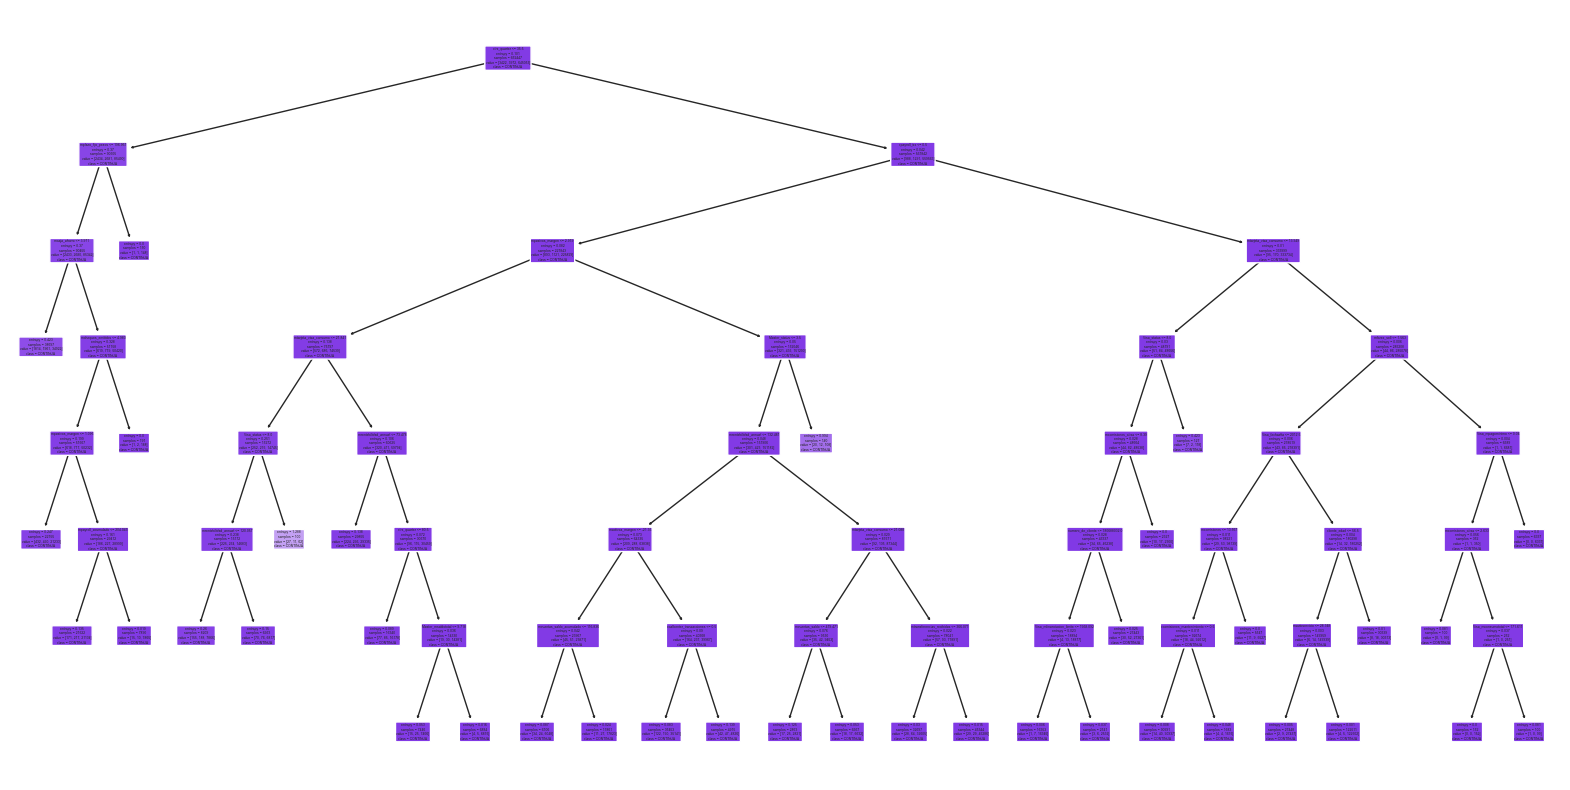

In [28]:
# Graficar el árbol
plt.figure(figsize=(20, 10))
plot_tree(modelo, feature_names=X_train.columns.tolist(), class_names=modelo.classes_.tolist(), filled=True, rounded=True)
plt.show()

In [18]:
imputer = SimpleImputer(strategy='mean')

In [19]:
X_apply_imputed = imputer.fit_transform(X_apply)

In [20]:
prediccion = modelo.predict_proba(X_apply_imputed)

In [21]:
prediccion

array([[1.07017333e-05, 5.13739914e-04, 9.99475558e-01],
       [3.34726333e-03, 5.03643057e-03, 9.91616306e-01],
       [1.25875533e-05, 2.34428355e-05, 9.99963970e-01],
       ...,
       [1.61265821e-02, 1.73185750e-02, 9.66554843e-01],
       [1.88683640e-02, 7.32509259e-03, 9.73806543e-01],
       [1.57578050e-02, 1.44451943e-02, 9.69797001e-01]])

In [22]:
# 'prediccion' es una matriz con tres columnas, mapeo a las clases "BAJA+1", "BAJA+2", y "CONTINUA"
# En este ejemplo se asume que las columnas del resultado siguen ese orden. Si es diferente, ajustarlo.
# Agregar la columna de probabilidades de BAJA+2
dapply["prob_baja2"] = prediccion[:, list(modelo.classes_).index("BAJA+2")]

/var/folders/jw/h3tdh_h111ndt1zqh3dxvhrm0000gn/T/ipykernel_51684/2124811798.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dapply["prob_baja2"] = prediccion[:, list(modelo.classes_).index("BAJA+2")]


In [23]:
dapply

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,mpayroll_acumulado,mpasivos_margen_acumulado,mcomisiones_acumulado,mcuentas_saldo_acumulado,prob_baja2
5,249221109,202106,1,0,0,62,305,2.352235,119.605176,12.443235,...,98.245235,9.0,0.0,7.728,BAJA+1,6113.597725,31.103141,73.033281,3218.181036,0.000514
11,249221468,202106,1,0,0,53,42,27.696294,136.630882,32.571412,...,482.242706,28.0,0.0,0.000,BAJA+1,0.000000,69.796951,132.144696,3029.170502,0.005036
17,249223005,202106,1,0,0,49,207,20.791176,224.750706,3.145412,...,15.705294,3.0,0.0,111.090,BAJA+1,5800.344785,29.491959,18.322225,655.242824,0.000023
23,249228180,202106,1,0,0,66,325,-0.816588,8.501765,2.457529,...,120.565588,6.0,0.0,10.695,BAJA+1,0.000000,6.562535,9.455398,0.197419,0.019264
29,249232117,202106,1,0,0,80,378,3.276412,214.521294,2.850412,...,264.346765,7.0,0.0,23.874,BAJA+1,1603.394760,29.775264,187.910915,1049.793686,0.003965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981941,1598444941,202106,0,0,0,27,1,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.000,BAJA+1,138.000000,0.000000,0.000000,0.000000,0.004965
981942,1598471047,202106,1,0,0,28,1,0.560000,0.560000,0.000000,...,NaN,NaN,NaN,0.000,BAJA+1,0.000000,0.477412,0.000000,538.685706,0.016132
981943,1598515897,202106,0,0,0,30,1,0.424000,0.424000,0.000000,...,NaN,NaN,NaN,0.000,BAJA+1,0.000000,0.361471,0.000000,422.652588,0.017319
981944,1598517059,202106,0,0,0,24,1,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,0.000,BAJA+1,685.709529,0.000000,0.000000,0.000000,0.007325


In [24]:
# Solo enviar estímulo a los registros con probabilidad de BAJA+2 mayor a 1/40
dapply["Predicted"] = (dapply["prob_baja2"] > 1/40).astype(int)

/var/folders/jw/h3tdh_h111ndt1zqh3dxvhrm0000gn/T/ipykernel_51684/2316859291.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dapply["Predicted"] = (dapply["prob_baja2"] > 1/40).astype(int)


In [25]:
dapply[dapply['Predicted']==1]

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,clase_ternaria,mpayroll_acumulado,mpasivos_margen_acumulado,mcomisiones_acumulado,mcuentas_saldo_acumulado,prob_baja2,Predicted
133,249283313,202106,1,0,0,85,325,12.993000,232.878235,9.569588,...,2.0,0.0,9.660,BAJA+1,0.0,3.585828,195.035487,138.892550,0.025241,1
139,249286746,202106,1,0,1,56,120,111.753588,1081.826882,23.837353,...,NaN,NaN,NaN,BAJA+1,0.0,83.486705,118.403650,-706.655757,0.040679,1
266,249394022,202106,1,0,0,56,276,20.188000,224.912647,11.425529,...,NaN,NaN,NaN,BAJA+1,0.0,52.499309,70.489356,3773.146245,0.025280,1
278,249424500,202106,0,0,1,69,325,22.352529,89.631059,18.020353,...,NaN,NaN,NaN,BAJA+1,0.0,0.000000,95.125209,-400.440407,0.057899,1
460,249590846,202106,0,0,0,46,261,0.008412,0.111882,0.000000,...,NaN,NaN,NaN,BAJA+1,0.0,0.047609,0.000000,3.726336,0.063806,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977436,1591509933,202106,1,0,0,28,3,-2.776588,3.270412,0.000000,...,0.0,0.0,0.000,BAJA+1,0.0,7.152802,10.282757,73.847792,0.025586,1
980430,1593812536,202106,1,0,0,36,2,-0.395588,-0.395588,0.000000,...,NaN,NaN,0.000,BAJA+1,0.0,0.210882,0.000000,-7.344471,0.028110,1
980460,1594468371,202106,1,0,0,19,2,1.646235,1.673000,1.507000,...,NaN,NaN,0.000,BAJA+1,0.0,0.000000,1.507000,-13.277422,0.025635,1
981881,1594868662,202106,1,0,0,25,2,0.193882,0.193882,0.170176,...,2.0,0.0,1.863,BAJA+1,0.0,0.296529,0.170176,-2.763412,0.030755,1


In [28]:
dapply.shape

(164876, 150)

In [26]:
# Guardar los resultados en un archivo CSV para Kaggle
dapply[["numero_de_cliente", "Predicted"]].to_csv("K101_008.csv", index=False, sep=",")